In [64]:
torch.__version__

'2.3.0+cu121'

In [1]:
import os
import torch
from models.model_builder import model_builder
import numpy as np
from scipy.stats import mode

import pandas as pd


class dotdict(dict):
  """dot.notation access to dictionary attributes"""
  __getattr__ = dict.get
  __setattr__ = dict.__setitem__
  __delattr__ = dict.__delitem__

args = dotdict()  
args.gpu = 0
args.use_multi_gpu = False
args.model_type = "tinyhar"
args.cross_channel_interaction_type = "attn"
args.cross_channel_aggregation_type = "FC"
args.temporal_info_interaction_type = "lstm"
args.temporal_info_aggregation_type = "tnaive"


# motionsense
# model_weight_path = "/pfs/data5/home/kit/tm/px6680/Conference/ISWC2023/Run_logs/logs/model_tinyhar_data_motionsense_seed_1_differencing_False_Seperation_False_magnitude_False_Mixup_0.5_RandomAug_0.5_oration_0.5_Mixupargmax_True_randomconfig_random_aug_all.yaml"
# args.data_name = "motionsense"

# dg
model_weight_path = "/pfs/data5/home/kit/tm/px6680/Conference/ISWC2023/Run_logs/logs/model_tinyhar_data_dg_seed_1_differencing_False_Seperation_False_magnitude_False_Mixup_0.5_RandomAug_0.5_Scaling_1.0_Mixupargmax_True_randomconfig_random_aug_all.yaml"
args.data_name = "dg"

# mhealth
# model_weight_path = "/pfs/data5/home/kit/tm/px6680/Conference/ISWC2023/Run_logs/logs/model_tinyhar_data_mhealth_seed_1_differencing_False_Seperation_False_magnitude_False_Mixup_0.5_RandomAug_0.5_oration_0.5_Mixupargmax_True_randomconfig_random_aug_all.yaml"
# args.data_name = "mhealth"

args.seed = 1
args.mixup_argmax = True
args.root_path = "../../../datasets"
args.filter_scaling_factor = 1.0
args.mixup_probability = 0.5
args.random_augmentation_prob = 0.5
args.random_augmentation_config_path = "random_aug_all.yaml"
args.batch_size = 128
args.fft_segments_length=16
args.use_gpu                 = True if torch.cuda.is_available() else False
args.window_save_path = "../Sliding_window"
args.to_save_path = "../Run_logs"
args.freq_save_path = "../Freq_data"
args.datanorm_type = "standardization"


import yaml
aug_config = open('configs/'+args.random_augmentation_config_path, mode='r')
aug_config = yaml.load(aug_config, Loader=yaml.FullLoader)
args.random_augmentation_config  = aug_config

# args.random_augmentation_config = {"jitter":True,
#                                    "moving_average":True,
#                                    "magnitude_scaling":True,
#                                    "magnitude_warp":True,
#                                    "magnitude_shift":True,
#                                    "time_warp":True,
#                                    "window_warp":True,
#                                    "window_slice":True,
#                                    "random_sampling":True,
#                                    "slope_adding":True
#                                    }

random_augmentation_nr = len(aug_config.keys())
# for key in args.random_augmentation_config.keys():
#     if args.random_augmentation_config[key]:
#         random_augmentation_nr = random_augmentation_nr+1
args.random_augmentation_nr = random_augmentation_nr


args.pos_select       = None
args.sensor_select    = None

if args.data_name ==  "skodar":
    args.exp_mode = "SOCV"

config_file = open('configs/data.yaml', mode='r')
data_config = yaml.load(config_file, Loader=yaml.FullLoader)
config = data_config[args.data_name]

args.root_path       =  os.path.join(args.root_path,config["filename"])
args.sampling_freq   =  config["sampling_freq"]
#print("-------------------delete num_classes-----------------")
args.num_classes     =  config["num_classes"]
window_seconds       =  config["window_seconds"]
args.windowsize      =  int(window_seconds * args.sampling_freq) 
args.input_length    =  args.windowsize


args.S_number_sensors_type= config["S_number_sensors_type"]
args.L_sensor_locations= config["L_sensor_locations"]
args.k_number_sensors_group= config["k_number_sensors_group"]
# input information
args.c_in            =  config["num_channels"]
if args.difference:
    args.c_in  = args.c_in * 2
if  args.filtering :
    for col in config["sensors"]:
        if "acc" in col:
            args.c_in = args.c_in+1



if args.wavelet_filtering :
    if args.windowsize%2==1:
        N_ds = int(torch.log2(torch.tensor(args.windowsize-1)).floor()) - 2
    else:
        N_ds = int(torch.log2(torch.tensor(args.windowsize)).floor()) - 2

    args.f_in            =  args.number_wavelet_filtering*N_ds+1
else:
    args.f_in            =  1






os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu) 
device = torch.device('cuda:{}'.format(args.gpu))

model = model_builder(args).double()#.to(device)

Build the TinyHAR model!


In [2]:
model.load_state_dict(torch.load(model_weight_path+'/cv_{}/final_best_vali.pth'.format(0)))

<All keys matched successfully>

In [3]:
from dataloaders import data_dict,data_set
dataset = data_dict[args.data_name](args)

 ----------------------- load all the data -------------------
-----------------------Sliding file are generated -----------------------
-----------------------Sliding file are generated -----------------------


In [4]:
data_x = dataset.data_x
data_y = dataset.data_y
data_y.reset_index(drop=True, inplace=True)


In [5]:
def majority_voting(data, window_size=5):
    # 确保窗口大小为奇数，便于取中心点

    

    n = len(data)
    smoothed_data = np.copy(data[window_size-1:])
    
    # 对每个点应用多数投票，考虑边界情况
    for i in range(window_size,n):
        # 计算窗口的起始和结束索引
        start = i-window_size
        end = i+1
        
        # 获取窗口内的数据
        window = data[start:end]
        
        # 计算众数
        result = mode(window)
        
        # 将窗口的中心点设置为众数
        smoothed_data[i-window_size] = result.mode[0]
    
    return smoothed_data

In [21]:

gt_list = []
pred_list = []

for index,item in enumerate(dataset.LOCV_keys):
    print(index)
    model.load_state_dict(torch.load(model_weight_path+'/cv_{}/final_best_vali.pth'.format(index)))
    print("-")
    filtered_df_x = data_x[data_x['sub'].isin(item)]

    train_keys = [i for i in dataset.all_keys if i not in item]
    filtered_df_train = data_x[data_x['sub'].isin(train_keys)].iloc[:,1:-1]
    mean = filtered_df_train.mean(0)
    std = filtered_df_train.std(0)



    filtered_df_x_sub_id = filtered_df_x.iloc[:,0]
    filtered_df_x_input = filtered_df_x.iloc[:,1:-1]
    filtered_df_x_sub = filtered_df_x.iloc[:,-1]

    filtered_df_x_input = (filtered_df_x_input - mean) / (std + np.finfo(float).eps)
    filtered_df_x = pd.concat([filtered_df_x_sub_id,filtered_df_x_input,filtered_df_x_sub], axis=1)
    
    #filtered_df_y = data_y[filtered_df_x.index]
    for subid in filtered_df_x["sub_id"].unique():
        print(subid)
        temp_x = filtered_df_x[filtered_df_x["sub_id"]==subid]
        temp_y = data_y[temp_x.index]
        temp_x.reset_index(drop=True, inplace=True)
        temp_y.reset_index(drop=True, inplace=True)

        for i in range(temp_x.shape[0]-args.windowsize):
            if i%10!=0:
                continue
            inputx = temp_x.iloc[i:i+args.windowsize,1:-1]
            gt_y = mode(temp_y.iloc[i:i+args.windowsize].values)[0][0]
            gt_list.append(gt_y)
            inputx = torch.tensor(np.expand_dims(np.expand_dims(np.array(inputx),0),0)).double()
            outputs = model(inputx)[0]
            pred = np.argmax(outputs.detach().cpu().numpy(),axis=0)
            pred_list.append(pred)
        assert 1==0



0
-
1_2


/scratch/slurm_tmpdir/job_23632060/ipykernel_428096/1842528769.py:36: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  gt_y = mode(temp_y.iloc[i:i+args.windowsize].values)[0][0]


AssertionError: 

In [22]:
window_size = 15
smoothed_pred_list  =majority_voting(pred_list,window_size)
cpped_pred_list = pred_list[window_size-1:]
cpped_gt_list = gt_list[window_size-1:]

/scratch/slurm_tmpdir/job_23632060/ipykernel_428096/4249985828.py:19: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  result = mode(window)


In [23]:
import matplotlib.pyplot as plt

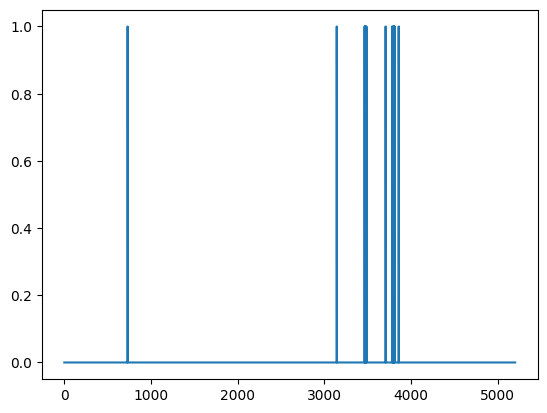

In [24]:
plt.plot(pred_list)

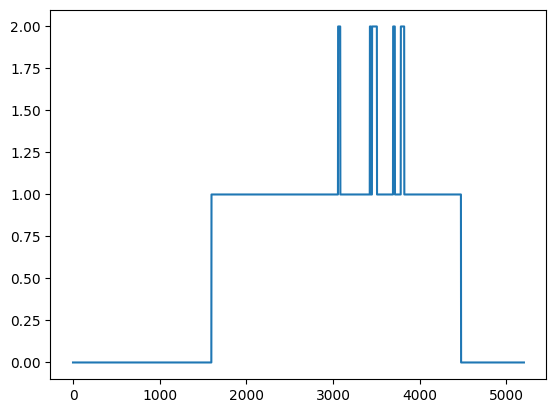

In [25]:
plt.plot(gt_list)

In [26]:
from sklearn.metrics import f1_score

f_macro_before = f1_score(cpped_gt_list, cpped_pred_list, average='macro')
f_macro_after = f1_score(cpped_gt_list, smoothed_pred_list, average='macro')

In [27]:
f_macro_before

0.2062789580147343

In [28]:
f_macro_after

0.20533333333333334

In [19]:
inputx = torch.tensor(np.expand_dims(np.expand_dims(np.array(inputx),0),0)).double()#.to(device)

outputs = model(inputx)[0]

np.argmax(outputs.detach().cpu().numpy(),axis=0)

0

In [47]:
def majority_voting(data, window_size=5):
    # 确保窗口大小为奇数，便于取中心点

    

    n = len(data)
    smoothed_data = np.copy(data[window_size-1:])
    
    # 对每个点应用多数投票，考虑边界情况
    for i in range(window_size,n):
        # 计算窗口的起始和结束索引
        start = i-window_size
        end = i+1
        
        # 获取窗口内的数据
        window = data[start:end]
        
        # 计算众数
        result = mode(window)
        
        # 将窗口的中心点设置为众数
        smoothed_data[i-window_size] = result.mode[0]
    
    return smoothed_data

In [48]:
majority_voting(pred_list)

/scratch/slurm_tmpdir/job_23631743/ipykernel_525109/4249985828.py:19: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  result = mode(window)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [18]:
model.load_state_dict(torch.load(model_weight_path+'/cv_{}/final_best_vali.pth'.format(0)))

<All keys matched successfully>

In [11]:
dataset.data_x

,sub_id,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,sub
0,1_dws_1,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,1
1,1_dws_1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,1
2,1_dws_1,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,1
3,1_dws_1,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,1
4,1_dws_1,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412860,24_std_14,-2.512274,-1.475547,0.560892,-0.055978,0.995467,0.076886,-0.048465,0.019469,0.001242,-0.000006,0.003480,0.003391,24
1412861,24_std_14,-2.514569,-1.474699,0.558068,-0.056297,0.995386,0.077698,-0.048469,0.012038,-0.005159,-0.007363,0.001165,-0.003677,24
1412862,24_std_14,-2.517105,-1.473640,0.555248,-0.056716,0.995284,0.078696,-0.045221,0.015253,-0.012618,-0.003800,-0.004638,0.001978,24
1412863,24_std_14,-2.515195,-1.472593,0.557282,-0.057477,0.995182,0.079431,-0.034644,-0.016695,-0.024255,-0.007647,-0.005009,-0.001688,24


In [12]:
dataset.LOCV_keys

筛选出sub的数据



[[1, 2],
 [3, 4],
 [5, 6],
 [7, 8, 9],
 [10, 11, 12],
 [13, 14, 15],
 [16, 17, 18],
 [19, 20],
 [21, 22],
 [23, 24]]

In [ ]:
filtered_df = df[df['column_name'].isin(values_to_select)]